# Using NSDF for anomalies detection in time series

<div>
    <center>
        <img src="files/docs/Logo.png" width="250"/>
    </center>
</div>

Colaborators: 

* Stanford Linear Accelerator Center (SLAC) 
* Super Cryogenic Dark Matter Search (SuperCDMS)
* Sudbury Neutrino Observatory Lab (SNOLAB)
* National Science Data Fabric (NSDF)

NSDF-Team:

* Heberth Martinez 
* Glenn Tarcea
* Giorgio Scorzelli
* Michela Taufer

## Preparing your Environment

The following cell prepares the environment by importing various crucial libraries for workflow execution. Please note that running this cell might take some time. Upon completion, a message will be displayed to notify you that the cell execution has finished.

In [41]:
%load_ext autoreload
%autoreload 2

In [3]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import warnings
import boto3
from botocore.client import Config
import os
import concurrent
from convert import ConvertJob
warnings.filterwarnings("ignore")

print("You have successfully prepared your environment.")

You have successfully prepared your environment.


## Accessing Data from Seal Storage

The following cell establishes a connection with a private storage service such as Seal Storage and downloads previously generated data

In [5]:
# print("Your download is starting...")

# with open("./files/json/data.json", "r") as file:
#     urls = json.load(file)

# config = Config(signature_version="s3v4")
# s3 = boto3.resource(
#     "s3",
#     endpoint_url="https://maritime.sealstorage.io/api/v0/s3",
#     aws_access_key_id="any",
#     aws_secret_access_key="any",
#     config=config,
#     verify=False,
# )
# bucket = s3.Bucket("utah")

# bucket.download_file(urls[0].get("key"), "data.npz")


# print("You have successfully downloaded the data from Seal Storage.")

## Download from CUTE Data


In [29]:
src_endpoint_url="https://ncsa.osn.xsede.org"
src_bucket_name="supercdms-data"
src_prefix="CDMS/CUTE"
dst_prefix="files/raw_cute"

def Connect(profile_name,endpoint_url,bucket_name, verify=True):
	session=boto3.session.Session(profile_name=profile_name)
	resource=session.resource('s3', endpoint_url=endpoint_url,verify=verify)
	bucket = resource.Bucket(bucket_name)
	client = session.client('s3', endpoint_url=endpoint_url, verify=verify)
	return dict(session=session, resource=resource, bucket=bucket, client=client)

ConnectSrc=lambda : Connect(profile_name='osn',endpoint_url=src_endpoint_url, bucket_name=src_bucket_name)

In [35]:
jobs=[]
for k,it in enumerate(ConnectSrc()['bucket'].objects.filter(Prefix=src_prefix)):
		src_key=it.key
		if src_key.endswith(".mid.gz"):
			local_filename=f"{dst_prefix}/{src_key}"
			dst_key=f"{dst_prefix}/{src_key}"
			done_filename=f"{local_filename}.done"
			# print (src_key,local_filename,dst_key,done_filename)
			if not os.path.exists(done_filename):
				os.makedirs(os.path.dirname(local_filename),exist_ok=True)
				print(f"Downloading {src_key} to {local_filename}")
				ConnectSrc()['bucket'].download_file(src_key, local_filename)
				print(f"Downloaded {src_key} to {local_filename}")
				# print(f"Uploading {local_filename} to {dst_key}")
				# ConnectDst()['bucket'].upload_file(local_filename, dst_key)
				# print(f"Uploaded {local_filename} to {dst_key}")
				print(f"Creating {done_filename}")
				open(done_filename, 'w').close()
				print(f"Created {done_filename}")
			else:
				print(f"Skipping {src_key} to {local_filename}")
			jobs.append((k,local_filename))
	


Skipping CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001.mid.gz to files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001.mid.gz
Skipping CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0045.mid.gz to files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0045.mid.gz


## Convert Cute data to generate json npz and xml


In [43]:
with concurrent.futures.ProcessPoolExecutor (max_workers=64) as executor:
    futures = [executor.submit(ConvertJob, *job) for job in jobs]
    for future in concurrent.futures.as_completed(futures):
        try:
            result = future.result()
            # print(f"Still todo {todo}")
        except Exception as ex:
            print(f'Error {ex}')

Doing 4 files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001.mid.gz
Doing 5 files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0045.mid.gz
Done 5 files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0045.mid.gz in 10.077183961868286 seconds
Done 4 files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001.mid.gz in 60.15653395652771 seconds


## Load data using Numpy

In [4]:
# load data using numpy
# npz = np.load("data.npz")
npz = np.load("/Users/jmarque4/jack/NSDF/nsdf-slac/files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001/events/00011/banks/SCD0/data.npz")
df = pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient="columns")
index = pd.date_range("1/1/2000", periods=df.shape[0], freq="1S")
print(df)

# # Creating train and test dataframes
# df.index = index
# new_df = df.iloc[: int(df.shape[0] * 0.9)]
# test_df = df.iloc[int(df.shape[0] * 0.9) :]

# # final data frame: frequency estimation
# final_df = new_df.asfreq(pd.infer_freq(new_df.index))

# print("You have successfully loaded the data.")
# print("Number of values: ", df.shape[0])

              data
0       2415951873
1       1342767104
2                8
3            10008
4              258
...            ...
147562  2139324184
147563  2684354560
147564           0
147565  4026531840
147566  2147483648

[147567 rows x 1 columns]


* Plot raw data using Matplotlib 

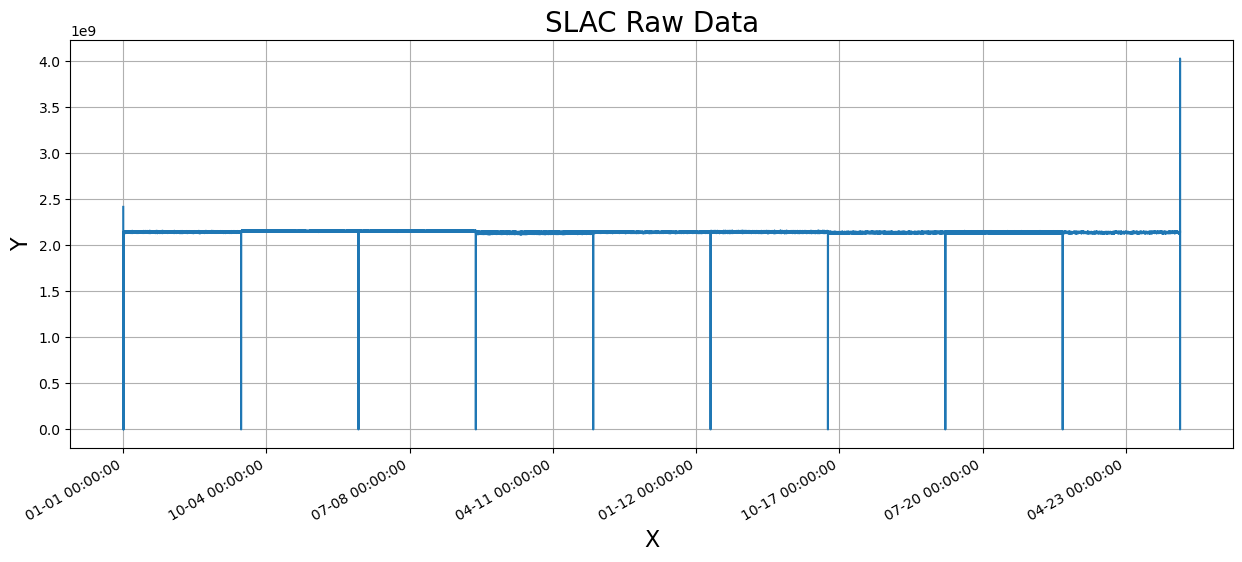

You have successfully plotted the data.


In [7]:
# plot train data
myFmt = mdates.DateFormatter("%m-%d %H:%M:%S")
plt.figure(figsize=(15, 6))
plt.plot(df)
plt.title("SLAC Raw Data", fontsize=20)
plt.ylabel("Y", fontsize=16)
plt.xlabel("X", fontsize=16)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()
print("You have successfully plotted the data.")